# ICR-pycaret

In [87]:
!pip install lightgbm
!pip install catboost
!pip install xgboost
!pip install tabpfn
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
 !pip install pycaret==3.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 3.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 4.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 6.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 370.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 5.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 6.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 8.4 MB/s eta 0:00:00
  Created wheel for plotly-resampler: filename=plotly_resampler-0.8.3.2-cp38-cp38-manylinux_2_31_aarch64.whl size=72144 sha256=93356cd9cf63c88bfcbcb05e3be32093c701b84ccb6a88156023f050a03b9471
  Stored in directory: /home/ubuntu/.cache/pip/wheels/63/17/b1/4bc002808e0370594fa673f71ecba27516bed8a83a334170e8
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184101 sha256=1e901aa4a04307b5513d7b3b76cc5

  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.2.1
    Uninstalling Werkzeug-2.2.1:
      Successfully uninstalled Werkzeug-2.2.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.2
    Uninstalling pandas-2.0.2:
      Successfully uninstalled pandas-2.0.2

[notice] A new release of pip available: 22.2.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [44]:
from pycaret.classification import *
import pycaret

In [45]:
print(pycaret.__version__)

3.0.2


## imports

In [88]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from tabpfn import TabPFNClassifier
import seaborn as sns

## read files

In [47]:
df = pd.read_csv("../input/icr-identify-age-related-conditions/train.csv", index_col=[0])
df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [48]:
df_test = pd.read_csv("../input/icr-identify-age-related-conditions/test.csv", index_col=[0])
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df['EJ'] = df['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)
df_test['EJ'] = df_test['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)

In [50]:
# # 外れ値除去
# def is_outlier(data, alpha):
#     mean = np.mean(data)
#     std = np.std(data)
#     threshold = mean + alpha * std
#     return data > threshold

# # 各列の外れ値をTrueにした行数分の配列を作成
# alpha = 20  # 外れ値として判定するためのαの値（例：2倍）
# outliers = np.zeros(df.shape[0], dtype=bool)
# for column in df.columns:
#     outliers = outliers | is_outlier(df[column].values, alpha)
    
# df = df[~outliers]

<function matplotlib.pyplot.show(close=None, block=None)>

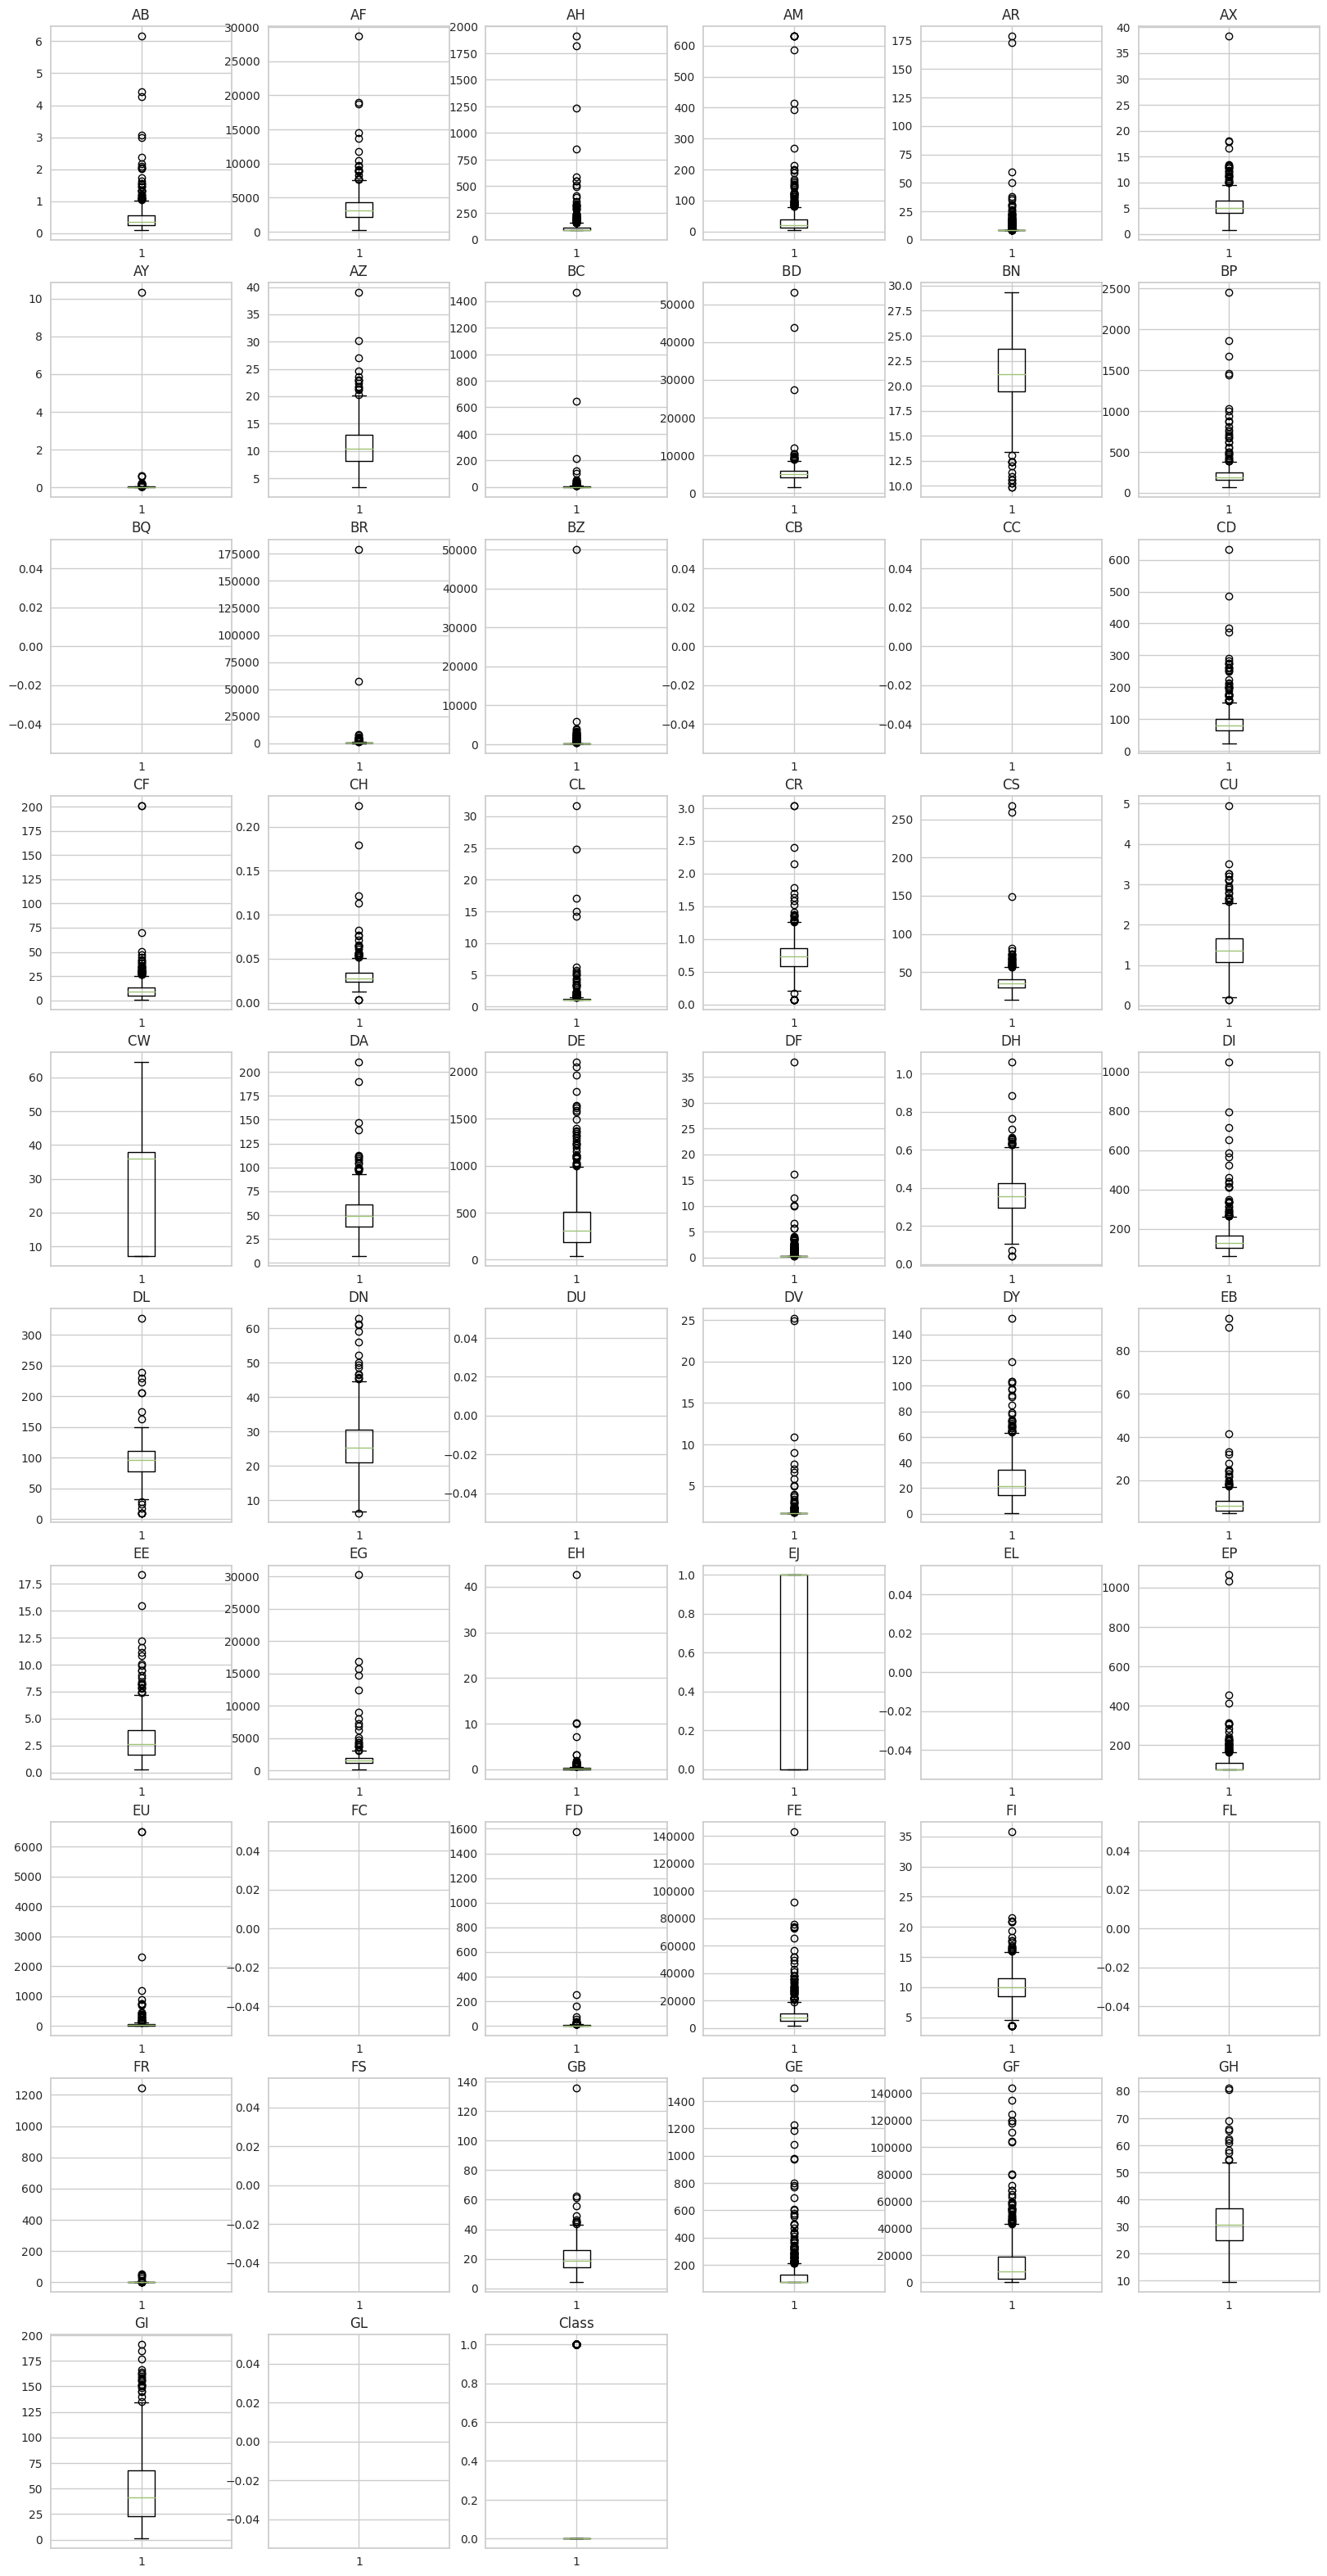

In [52]:
plt.figure(figsize=(20,40))
for i, col in enumerate(df.columns) :
    plt.subplot(10, 6, i+1)
    h = plt.boxplot(df[col])
    plt.title(col)
plt.show

In [84]:
num_cols = df.select_dtypes(include=['float64']).columns.tolist()

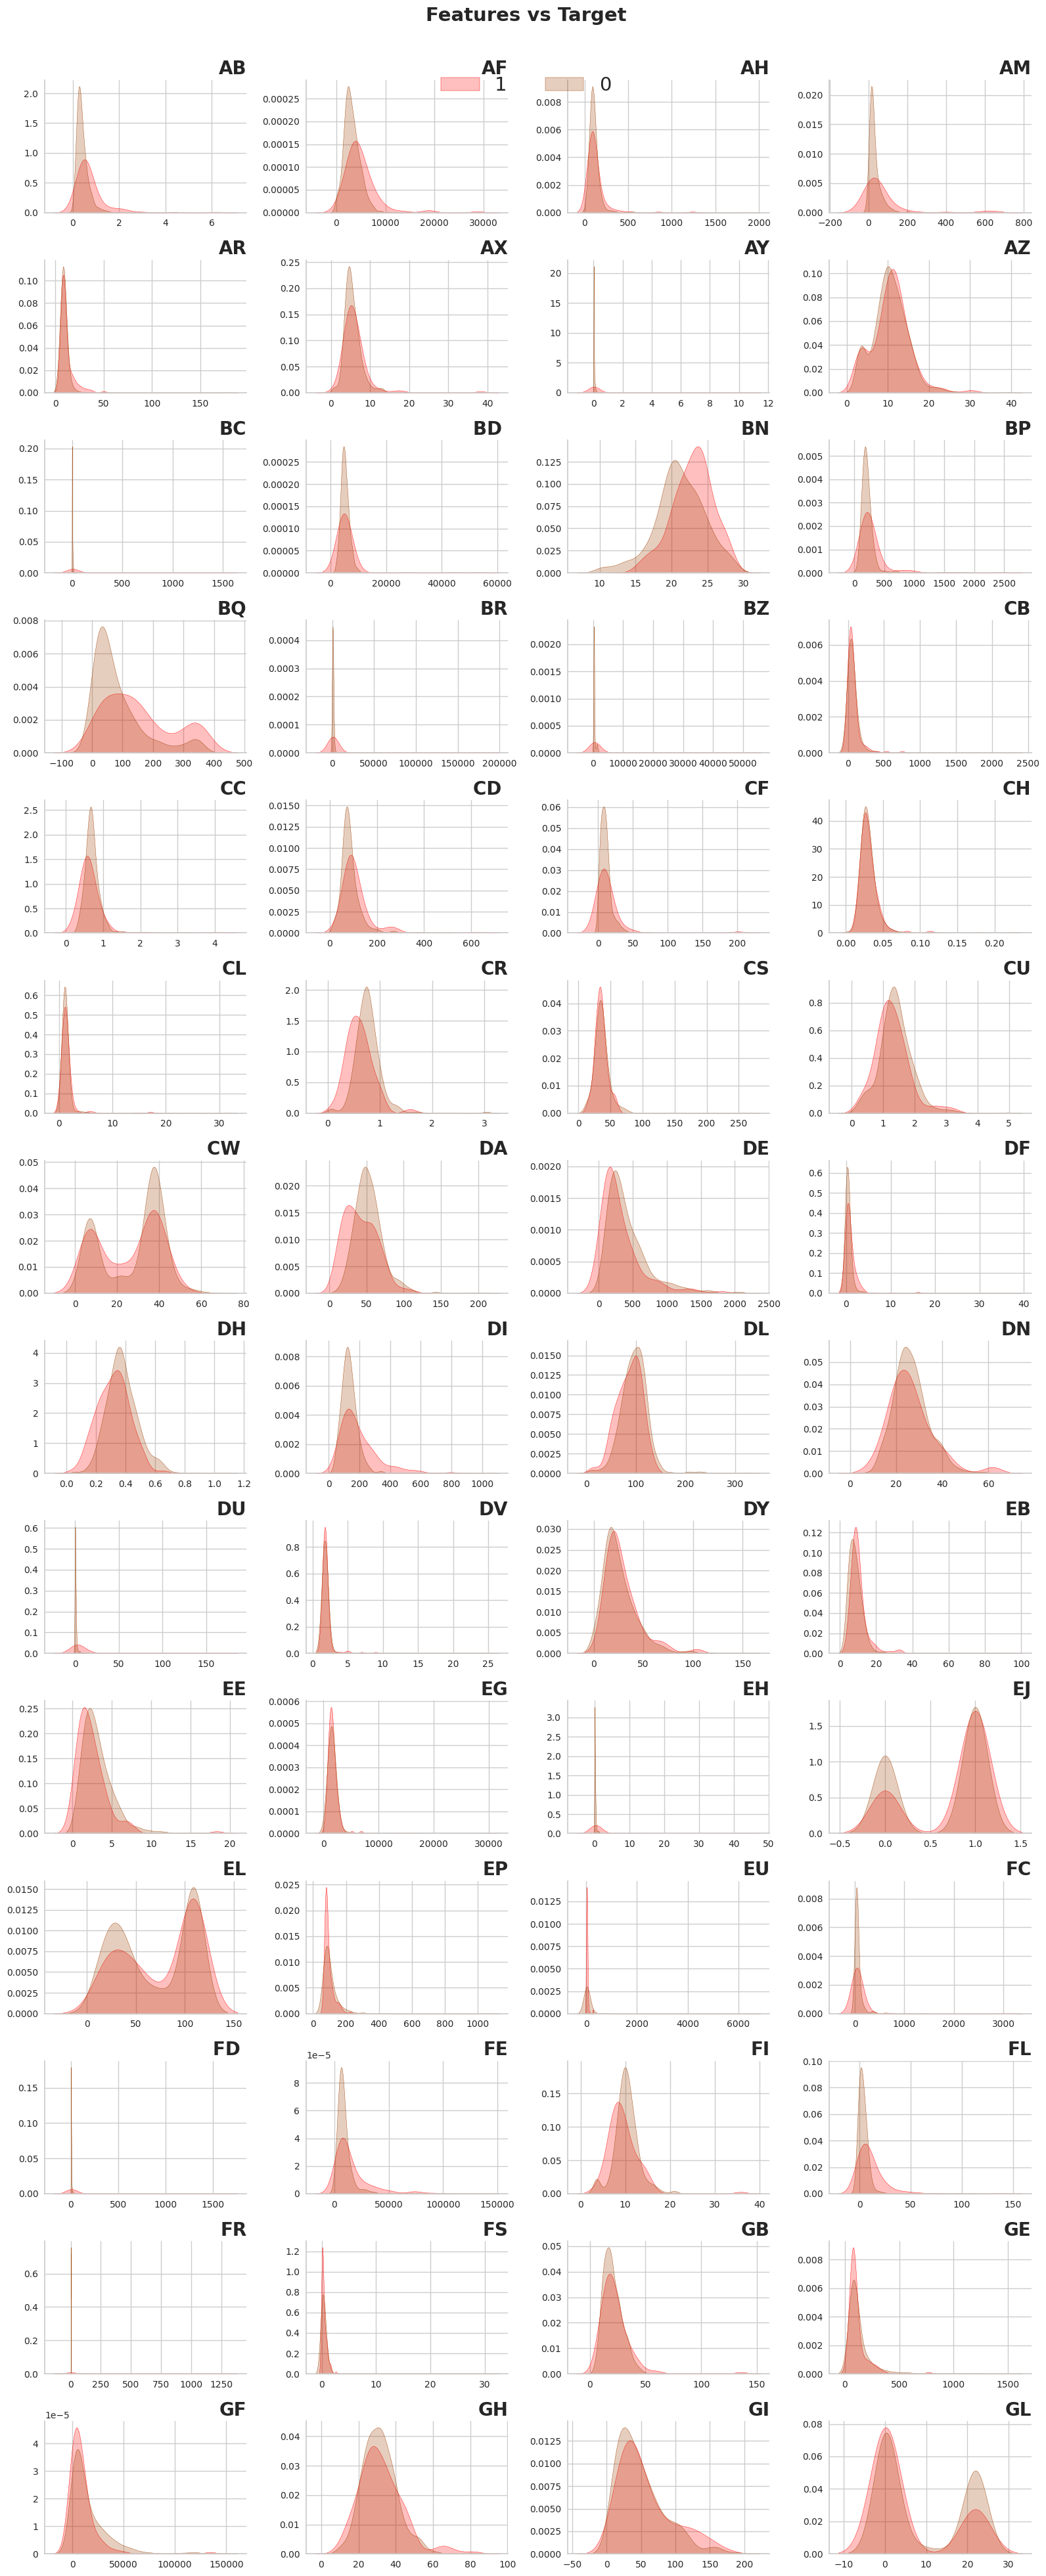

In [99]:
# class0と１の分布が大きくずれているものがないか俯瞰する
figsize = (4*4, 40)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols):
    ax = plt.subplot(14,4, idx + 1)
    sns.kdeplot(
        data=df, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False,
        common_norm=False, # 個別にスケールする
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

In [53]:
# import os, random

# def seed_everything(seed: int):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)

# seed_everything(42)

## pycaret

In [54]:
def balanced_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

# 独自の評価関数をスコアリング関数に変換
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False)

In [55]:
exp1 = setup(df, target = 'Class', ignore_features = ['Id'], session_id=42, fix_imbalance=True, remove_outliers=False)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(617, 57)"
4,Transformed data shape,"(898, 57)"
5,Transformed train set shape,"(712, 57)"
6,Transformed test set shape,"(186, 57)"
7,Ignore features,1
8,Numeric features,56
9,Rows with missing values,11.2%


In [12]:
count_1 = df['Class'].sum()
count_0 = df['Class'].count() - count_1

# Calculate the ratio
ratio = count_1 / count_0
ratio

0.21218074656188604

In [66]:
classification_models = models()
tabpfn = TabPFNClassifier(N_ensemble_configurations=64) 

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [67]:
# モデルの構築
models = compare_models(n_select = 3, sort='AUC') # , probability_threshold = ratio)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,TabPFNClassifier,0.9144,0.9408,0.6464,0.8490,0.7263,0.6771,0.6906,2.7630


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [101]:
models = [
    create_model("xgboost"),
    create_model("catboost"),    
    create_model("lightgbm"),
    create_model(tabpfn)
]
models

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9318,0.9618,0.7500,0.8571,0.8000,0.7591,0.7616
1,0.9070,0.9444,0.8571,0.6667,0.7500,0.6940,0.7022
2,0.9070,0.9683,0.8571,0.6667,0.7500,0.6940,0.7022
3,0.9070,0.9563,1.0000,0.6364,0.7778,0.7226,0.7521
4,0.9302,0.8810,0.7143,0.8333,0.7692,0.7284,0.7314
5,0.9767,0.9802,0.8571,1.0000,0.9231,0.9095,0.9132
6,0.9535,0.9857,0.8750,0.8750,0.8750,0.8464,0.8464
7,0.9302,0.9750,0.8750,0.7778,0.8235,0.7802,0.7823
8,0.9302,0.9786,0.7500,0.8571,0.8000,0.7580,0.7605


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9545,0.9444,0.7500,1.0000,0.8571,0.8308,0.8429
1,0.9070,0.9524,0.8571,0.6667,0.7500,0.6940,0.7022
2,0.9535,0.9921,1.0000,0.7778,0.8750,0.8470,0.8571
3,0.9070,0.9722,1.0000,0.6364,0.7778,0.7226,0.7521
4,0.9070,0.8810,0.8571,0.6667,0.7500,0.6940,0.7022
5,0.9535,0.9802,0.7143,1.0000,0.8333,0.8072,0.8226
6,0.9767,0.9964,1.0000,0.8889,0.9412,0.9267,0.9292
7,0.9302,0.9786,0.8750,0.7778,0.8235,0.7802,0.7823
8,0.9302,0.9750,0.7500,0.8571,0.8000,0.7580,0.7605


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9318,0.9340,0.7500,0.8571,0.8000,0.7591,0.7616
1,0.8837,0.9563,0.8571,0.6000,0.7059,0.6362,0.6519
2,0.9535,0.9762,1.0000,0.7778,0.8750,0.8470,0.8571
3,0.9535,0.9524,1.0000,0.7778,0.8750,0.8470,0.8571
4,0.9302,0.9008,0.7143,0.8333,0.7692,0.7284,0.7314
5,0.9535,1.0000,0.7143,1.0000,0.8333,0.8072,0.8226
6,0.9767,1.0000,0.8750,1.0000,0.9333,0.9193,0.9223
7,0.9302,0.9714,0.7500,0.8571,0.8000,0.7580,0.7605
8,0.9302,0.9714,0.7500,0.8571,0.8000,0.7580,0.7605


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7955,0.8264,0.3750,0.4286,0.4000,0.2774,0.2783
1,0.8605,0.9563,0.5714,0.5714,0.5714,0.4881,0.4881
2,0.9535,0.9802,0.8571,0.8571,0.8571,0.8294,0.8294
3,0.9767,0.9960,0.8571,1.0000,0.9231,0.9095,0.9132
4,0.9302,0.8492,0.7143,0.8333,0.7692,0.7284,0.7314
5,0.9535,0.9246,0.7143,1.0000,0.8333,0.8072,0.8226
6,0.9302,0.9821,0.6250,1.0000,0.7692,0.7307,0.7587
7,0.9535,0.9821,0.7500,1.0000,0.8571,0.8300,0.8423
8,0.8837,0.9500,0.5000,0.8000,0.6154,0.5511,0.5723


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


[XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=-1, num_parallel_tree=None,
               objective='binary:logistic', predictor=None, ...),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split

In [116]:
# for i in range(len(models)-1):
#     models[i] = tune_model(models[i], optimize = "AUC", fold = 10, n_iter = 25)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8864,0.9444,0.6250,0.7143,0.6667,0.5985,0.6005
1,0.8372,0.9484,0.8571,0.5000,0.6316,0.5362,0.5683
2,0.9070,0.9603,1.0000,0.6364,0.7778,0.7226,0.7521
3,0.9070,0.9563,1.0000,0.6364,0.7778,0.7226,0.7521
4,0.8837,0.8810,0.8571,0.6000,0.7059,0.6362,0.6519
5,0.9535,0.9643,0.8571,0.8571,0.8571,0.8294,0.8294
6,0.9302,0.9929,1.0000,0.7273,0.8421,0.7988,0.8154
7,0.9070,0.9607,0.8750,0.7000,0.7778,0.7199,0.7270
8,0.9535,0.9893,0.8750,0.8750,0.8750,0.8464,0.8464


Fitting 10 folds for each of 25 candidates, totalling 250 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9318,0.9375,0.7500,0.8571,0.8000,0.7591,0.7616
1,0.8605,0.9563,0.8571,0.5455,0.6667,0.5839,0.6077
2,0.9070,0.9881,0.8571,0.6667,0.7500,0.6940,0.7022
3,0.8837,0.9643,1.0000,0.5833,0.7368,0.6687,0.7087
4,0.9070,0.8968,0.7143,0.7143,0.7143,0.6587,0.6587
5,0.9767,0.9881,0.8571,1.0000,0.9231,0.9095,0.9132
6,0.9535,0.9893,0.8750,0.8750,0.8750,0.8464,0.8464
7,0.9070,0.9679,0.7500,0.7500,0.7500,0.6929,0.6929
8,0.9302,0.9821,0.7500,0.8571,0.8000,0.7580,0.7605


Fitting 10 folds for each of 25 candidates, totalling 250 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8864,0.9514,0.6250,0.7143,0.6667,0.5985,0.6005
1,0.8837,0.9603,0.8571,0.6000,0.7059,0.6362,0.6519
2,0.9535,0.9802,1.0000,0.7778,0.8750,0.8470,0.8571
3,0.9302,0.9722,0.8571,0.7500,0.8000,0.7580,0.7605
4,0.9302,0.8968,0.8571,0.7500,0.8000,0.7580,0.7605
5,0.9070,0.9960,0.4286,1.0000,0.6000,0.5567,0.6211
6,0.9302,0.9821,0.6250,1.0000,0.7692,0.7307,0.7587
7,0.9535,0.9929,0.8750,0.8750,0.8750,0.8464,0.8464
8,0.9767,0.9964,0.8750,1.0000,0.9333,0.9193,0.9223


Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [103]:
# rf = create_model('rf')
# tuned_rf = tune_model(rf, n_iter = 10, optimize = 'r2')

In [118]:
blender_specific = blend_models(estimator_list = models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9091,0.9340,0.7500,0.7500,0.7500,0.6944,0.6944
1,0.9070,0.9603,0.8571,0.6667,0.7500,0.6940,0.7022
2,0.9302,0.9802,0.8571,0.7500,0.8000,0.7580,0.7605
3,0.9302,0.9802,1.0000,0.7000,0.8235,0.7817,0.8010
4,0.9302,0.8810,0.7143,0.8333,0.7692,0.7284,0.7314
5,0.9767,0.9762,0.8571,1.0000,0.9231,0.9095,0.9132
6,0.9535,0.9929,0.7500,1.0000,0.8571,0.8300,0.8423
7,0.9535,0.9857,0.8750,0.8750,0.8750,0.8464,0.8464
8,0.9302,0.9857,0.7500,0.8571,0.8000,0.7580,0.7605


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [119]:
models

[XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=-1, num_parallel_tree=None,
               objective='binary:logistic', predictor=None, ...),
 LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
                importance_type='split', learning_rate=0.3, max_depth

In [120]:
# tuned_blender = tune_model(blender_specific) #, optimize = "mae", fold = 10, n_iter = 50)
# tuned_blender
predict_model(blender_specific, data=df[df.columns[:-1]], raw_score=True)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FS,GB,GE,GF,GH,GI,GL,prediction_label,prediction_score_0,prediction_score_1
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.033203,85.200150,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.587402,...,0.094822,11.339138,72.611061,2003.810303,22.136229,69.834946,0.120343,1,0.0029,0.9971
007255e47698,0.145282,978.764160,85.200150,36.968887,8.138688,3.632190,0.025578,13.517790,1.229900,5496.928223,...,0.568932,9.292698,72.611061,27981.562500,29.135429,32.131996,21.978001,0,0.9998,0.0002
013f2bd269f5,0.470030,2635.106445,85.200150,32.360554,8.138688,6.732840,0.025578,12.824570,1.229900,5135.780273,...,1.198821,37.077770,88.609436,13676.958008,28.022852,35.192677,0.196941,0,0.9772,0.0228
043ac50845d5,0.252107,3819.651855,120.201614,77.112206,8.138688,3.685344,0.025578,11.053708,1.229900,4169.677246,...,0.284466,18.529585,82.416801,2094.262451,39.948654,90.493248,0.155829,0,0.9929,0.0071
044fb8a146ec,0.380297,3733.048340,85.200150,14.103738,8.138688,3.942255,0.054810,3.396778,102.151978,5728.733887,...,0.121914,16.408728,146.109940,8524.370117,45.381317,36.262627,0.096614,0,0.7149,0.2851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.059570,123.763596,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.684570,...,0.067730,8.967128,217.148560,8095.932617,24.640463,69.191940,21.978001,0,0.9897,0.0103
fd895603f071,0.435846,5462.034180,85.200150,46.551006,15.973224,5.979825,0.025882,12.622906,3.777550,5654.075684,...,0.426699,35.896420,496.994202,3085.308105,29.648928,124.808868,0.145340,0,0.9282,0.0718
fd8ef6377f76,0.427300,2459.107178,130.138580,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.877930,...,0.067730,19.962091,128.896896,6474.652832,26.166073,119.559418,21.978001,0,0.9989,0.0011


In [ ]:
pred = predict_model(blender_specific, data=df[df.columns[:-1]], raw_score=True)[['prediction_score_1']].clip(0, 1)
print(pred)

In [ ]:
pred['Class'] = df['Class']

In [ ]:
pred

In [ ]:
balanced_log_loss(pred['Class'], pred['prediction_score_1'])

In [ ]:
evaluate_model(blender_specific)

In [ ]:
save_model(blender_specific, 'blend_model')

# inference

In [ ]:
model = load_model('blend_model')

In [ ]:
pred = predict_model(model, data=df_test, raw_score=True)['prediction_score_1'].to_numpy()
pred

In [ ]:
sub = pd.read_csv('../input/icr-identify-age-related-conditions/sample_submission.csv')
sub['class_1'] = pred
sub['class_0'] = 1 - pred
sub.to_csv('submission.csv', index=False)
sub